### Aplicando segmentación basada en densidad

El objetivo de esta sección es evaluar el agrupamiento de valores por su densidad y determinar si es una técnica viable para identificar afecciones dentales como caries, las cuales se presentan como zonas más densas en las radiografías dentales.

Para lograr este objetivo aprovecharemos que en una etapa anterior del proyecto ya identificamos que era posible usar 700 componentes para mantener el 99% de la varianza de las imagenes y mantener una buena legibilidad de las mismas.  Aprovechando ese procesamiento previo sobre las imagenes esperamos poder ejecutar modelos de DBSCAN de manera óptima sobre las imagenes con dimensionalidad reducida, pues DBSCAN es considerado computacionalmente costoso para conjuntos de datos de altas dimensiones.

In [3]:
# Importar librerías
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pca import pca
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Tomamos una imagen al azar que nos sirva de referencia para evaluar el modelo DBSCAN. Una vez se identifiquen los hiperparámetros del modelo podemos aplicarlo sobre el conjunto de imagenes completo y evaluar los resultados.

In [6]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 11)

In [8]:
sample = df[df['file_name'] == 'Adult_11.png']
sample

full_path main_folder intermediate_path  \
12  2_Cleaned_dataset\images\Adult_11.png      images            images   

       file_name category format  height  width   size  bands  \
12  Adult_11.png    Adult    PNG     188    398  35843      1   

                                                image  
12  [[174, 163, 156, 151, 150, 142, 143, 142, 143,...

(188, 398, 3)


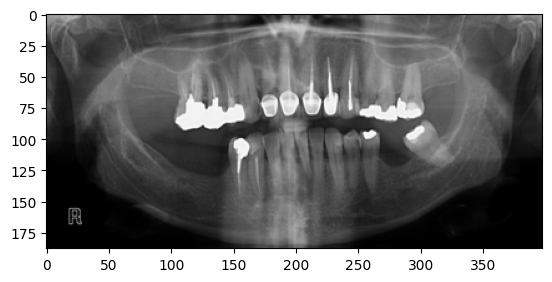

In [9]:
img_filename = '2_Cleaned_dataset/images/Adult_11.png'
image = cv2.imread(img_filename)
print(image.shape)
plt.imshow(image)

In [10]:
# Aplanamos las imágenes antes de crear una matriz de valores estandarizados
X = np.stack(df['image'].apply(lambda x: x.flatten()))
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
X_standardized_df = pd.DataFrame(X_standardized)

Entrenamos un modelo PCA con los parámetros ya identificados

In [11]:
pca_model = PCA(n_components=300)
pca_model.fit(X_standardized_df)
X_reduced = pca_model.transform(X_standardized_df)

Recreamos la imagen reducida

In [12]:
sample_image = pca_model.inverse_transform([X_reduced[12]])

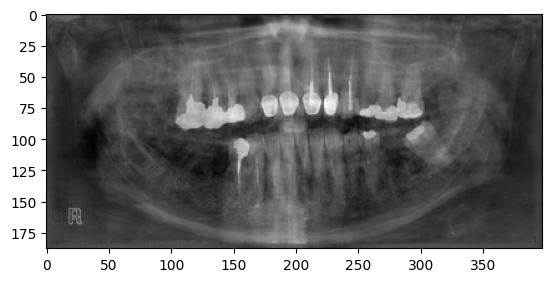

In [13]:
plt.imshow(sample_image.reshape((188, 398)), cmap='gray')

Y aplicamos DBSCAN sobre esta imagen reducida de referencia.

In [20]:
X = image.reshape(-1, 1)
f"Tipo: {type(X)} - Dimensiones: {X.ndim} - Longitud: {len(X)} - Longitud dim 0: {len(X[0])} - Longitud dim 1: {len(X[1])}"

"Tipo: <class 'numpy.ndarray'> - Dimensiones: 2 - Longitud: 224472 - Longitud dim 0: 1 - Longitud dim 1: 1"

Establecemos valores de epsilon y puntos mínimos al azar y `cosine` como metrica de medicion de la distancia entre puntos, ya que este es uno de los más costosos en ejecución.  El objetivo es determinar si con el hardware actual podemos ejecutar un modelo DBSCAN, pues es un modelo computacionalmente costoso.

In [18]:
dbscan = DBSCAN(eps=0.002, min_samples=500, metric='cosine')
dbscan.fit(X)

MemoryError: Unable to allocate 1.57 MiB for an array with shape (206286, 1) and data type int64

... Notamos que el proceso no finalizó por falta de memoria.  Decidimos entonces ejecutar el proceso en un equipo con 16 Mb de RAM y en Google COLAB con diferentes configuraciones pero no fue posible determinar el tiempo de procesamiento para este escenario, porque las prestaciones de hardware fueron insuficientes, optamos entonces por reducir aún más la dimensionalidad de las imagenes.

El nuevo criterio para reducir las imágenes fue recortar desde los bordes hacia el centro cierta cantidad de pixeles, de manera que obtengamos solo el área de la imagen que contiene los dientes y sus raices que es considerada relevante para este análisis.

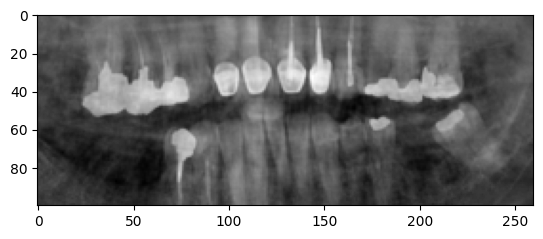

In [24]:
# Creamos una función para recortar una imagen
def cut_image(image, coords, show=False, saveToFile=None):
    caption = image[coords[1]:coords[1] + coords[3], coords[0]:coords[0] + coords[2]]

    if show:
        plt.imshow(caption, cmap='gray')

    if saveToFile:
        cv2.imwrite(saveToFile, caption)

    return caption

caption = cut_image(sample_image.reshape((188, 398)), coords=(80, 40, 260, 100), show=True)

In [25]:
X4 = sample_image.reshape(-1, 1)
f"Tipo: {type(X4)} - Dimensiones: {X4.ndim} - Longitud: {len(X4)} - Longitud dim 0: {len(X4[0])} - Longitud dim 1: {len(X4[1])}"

"Tipo: <class 'numpy.ndarray'> - Dimensiones: 2 - Longitud: 74824 - Longitud dim 0: 1 - Longitud dim 1: 1"

La resolución de esta imagen recortada es de 100 x 260


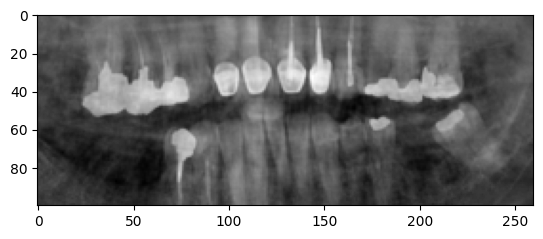

In [28]:
caption4 = cut_image(sample_image.reshape((188, 398)), coords=(80, 40, 260, 100), show=True)
print(f"La resolución de esta imagen recortada es de {caption4.shape[0]} x {caption4.shape[1]}")

In [30]:
X4_ = caption4.reshape(-1, 1)
f"Tipo: {type(X4_)} - Dimensiones: {X4_.ndim} - Longitud: {len(X4_)} - Longitud dim 0: {len(X4_[0])} - Longitud dim 1: {len(X4_[1])}"

"Tipo: <class 'numpy.ndarray'> - Dimensiones: 2 - Longitud: 26000 - Longitud dim 0: 1 - Longitud dim 1: 1"

De esta manera pasamos de manejar una imagen representada por un array de 224472 posiciones a un array de 26000 posiciones.

Intentamos aplicar DBSCAN sobre esta imagen recortada

In [31]:
dbscan4 = DBSCAN(eps=0.002, min_samples=500, metric='cosine', n_jobs=-1)
dbscan4.fit(X4_)
unique_labels = np.unique(dbscan4.labels_)
unique_labels

array([0, 1], dtype=int64)

De esta manera, logramos ejecutar el modelo en 24 segundos en el pc inicial.  Podemos con esta mejora proceder a identificar los mejores hiperparámetros para nuestro modelo DBSCAN.

Recordemos que DBSCAN es un algoritmo de clustering que se basa en la densidad de los puntos en el espacio de características para agruparlos en clústeres. A diferencia de algunos algoritmos de clustering, como k-means, DBSCAN no produce una puntuación o métrica intrínseca de calidad del clustering que se pueda utilizar para evaluar su desempeño de manera directa.

La razón principal es que DBSCAN se centra en encontrar regiones densas en el espacio de características y no hace suposiciones predefinidas sobre la forma o la cantidad de clústeres en los datos. Esto significa que DBSCAN puede manejar datos con formas y tamaños de clústeres irregulares, lo que lo hace ideal para nuestro escenario de análisis. Sin embargo, también implica que no se puede utilizar una métrica global de calidad del clustering, en cambio, la evaluación la realizamos de manera cualitativa y visual.

Para evaluar el desempeño crearemos un par de funciones que nos permitan visualizar una muestra de las diferentes combinaciones de hiperparámetros para identificar cuál de estas combinaciones nos puede llevar a resaltar afecciones como la caries.

In [32]:
# Creamos una función para crear una instancia de DBSCAN con los parámetros especificados.
def eval_dbscan(base_image, eps, min_samples, metric):
    # Creamos y entrenamos el modelo
    X_flat = caption4.reshape(-1, 1)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    dbscan.fit(X_flat)
    unique_labels = np.unique(dbscan.labels_)
    
    # Cambiar el tipo de datos del array de la imagen original a np.float32
    img = base_image.astype(np.float32)

    # Obtener las etiquetas de los clústeres
    labels = dbscan.labels_

    # Crear una copia de la imagen original
    img_clusters = img.copy()
    img_clusters = np.zeros_like(img_clusters) # Dejar todo en negro

    # Identificamos los puntos que no son ruido
    valid_indices = np.where(labels != -1)[0]

    # Reemplazar los valores de los píxeles por los colores de los clústeres
    for i in valid_indices:
        # Obtener las coordenadas del píxel i
        x, y = i // img.shape[1], i % img.shape[1]
        
        # Obtener la etiqueta del clúster del píxel i
        label = labels[i]
        img_clusters[x, y] = label

    # Mostrar la imagen original y la imagen con los clústeres resaltados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_clusters, cmap='magma')
    plt.title(f"{len(unique_labels)} clústers ({metric}, eps: {eps}, min_samples:{min_samples})")
    plt.axis("off")
    
    plt.show()

# Creamos una función que nos permita evaluar modelos de DBSCAN con diferentes combinaciones de hiperparámetros 
def evaluate_dbscan_hyperparameters(base_image, eps_values, min_samples_values, metric_values):
    # Genera todas las combinaciones de hiperparámetros
    hyperparameter_combinations = itertools.product(eps_values, min_samples_values, metric_values)
    
    # Itera a través de las combinaciones de hiperparámetros
    for eps, min_samples, metric in hyperparameter_combinations:
        eval_dbscan(base_image, eps, min_samples, metric)

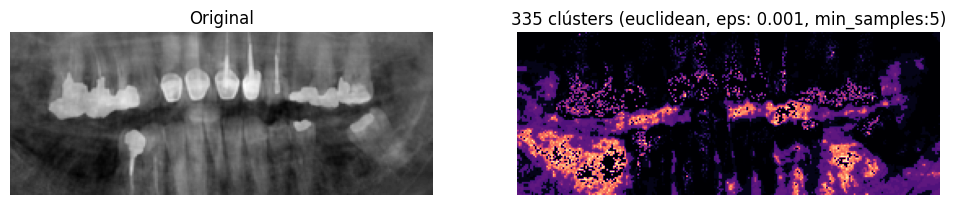

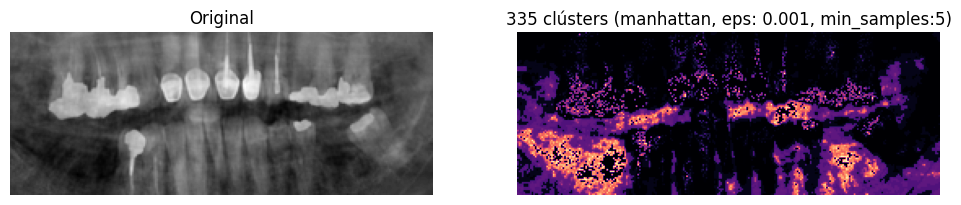

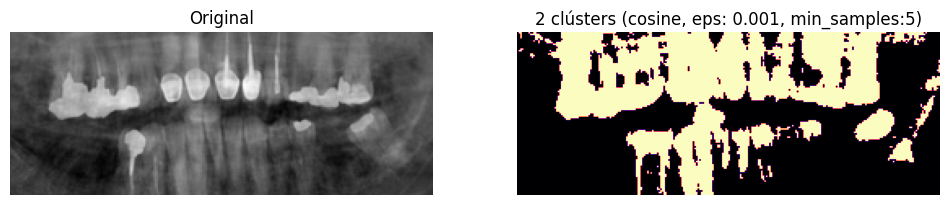

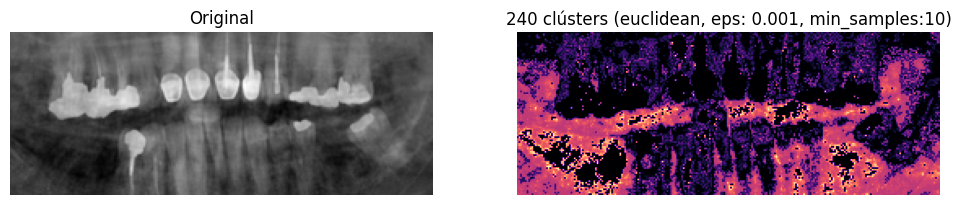

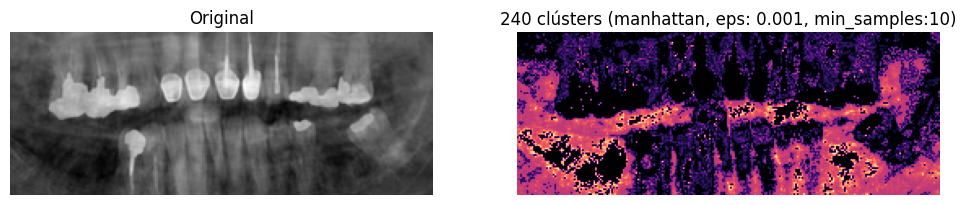

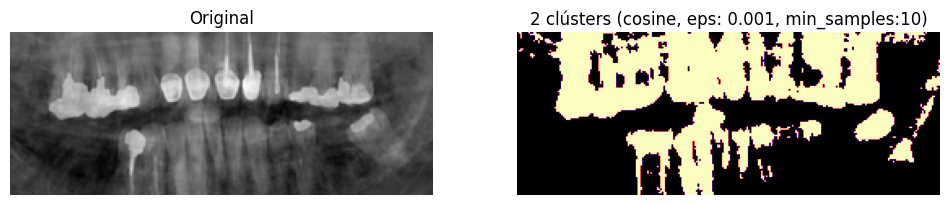

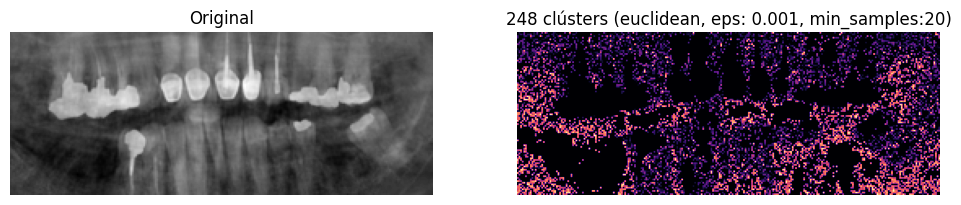

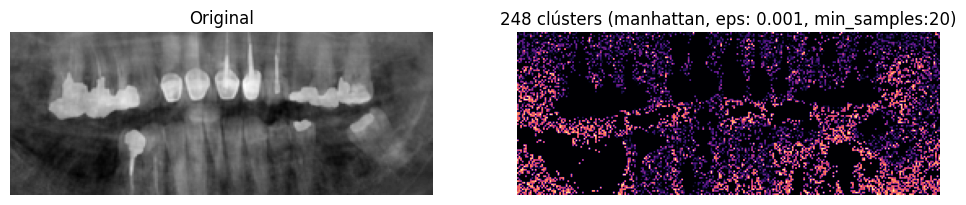

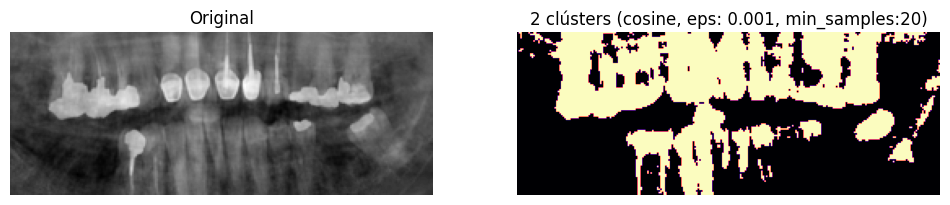

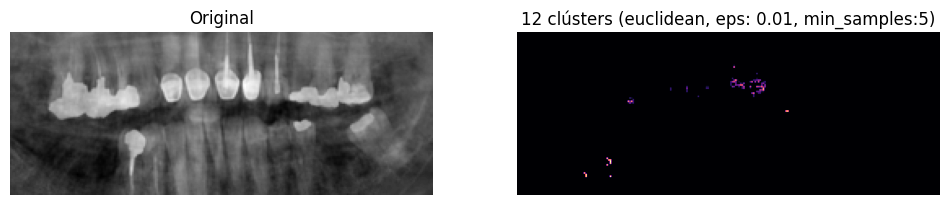

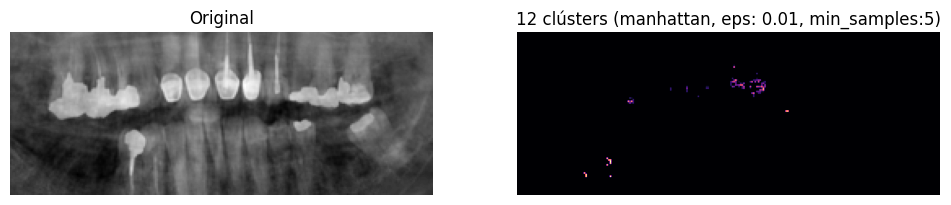

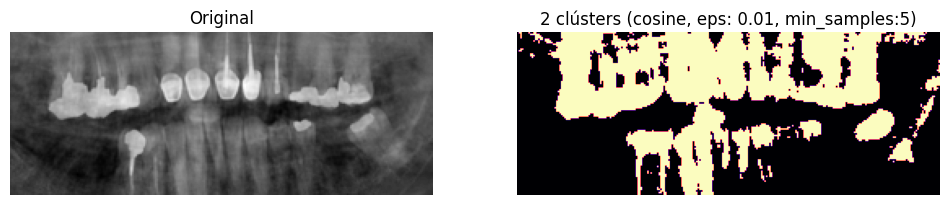

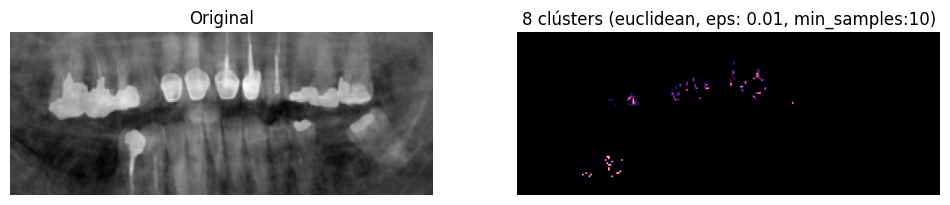

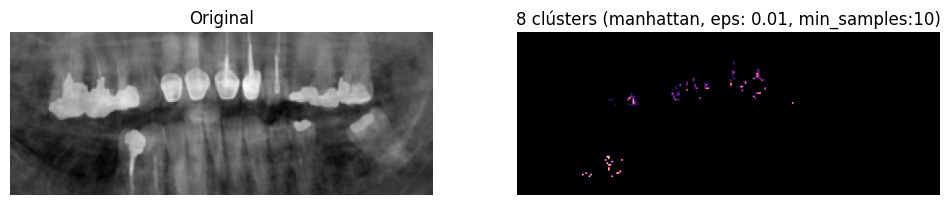

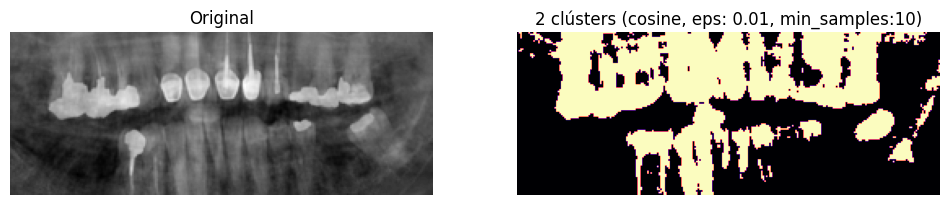

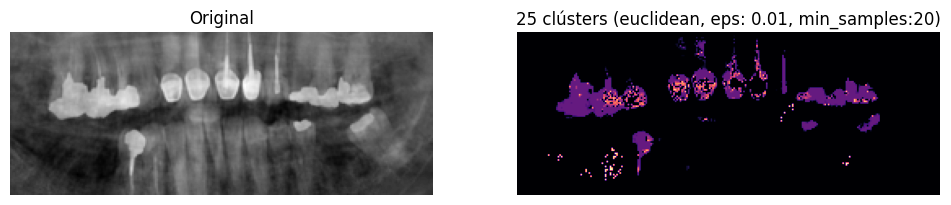

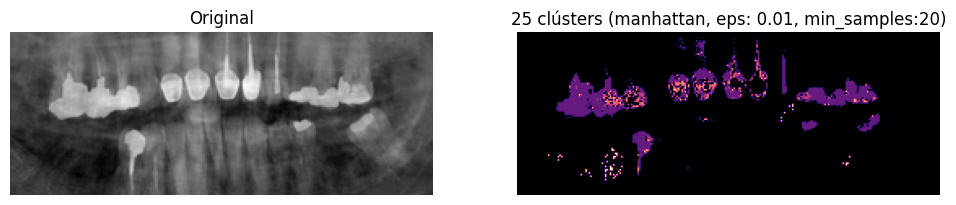

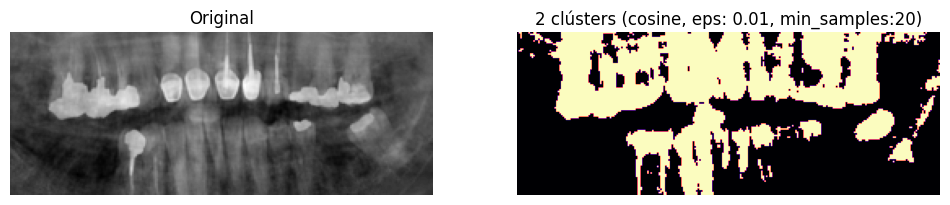

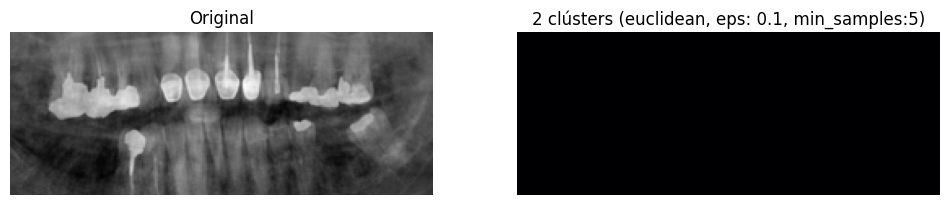

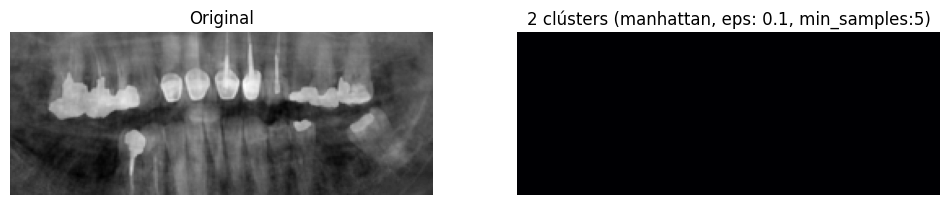

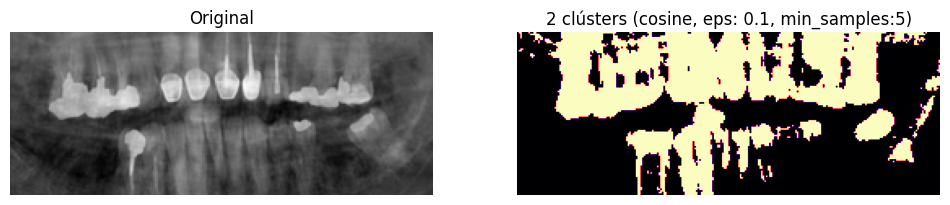

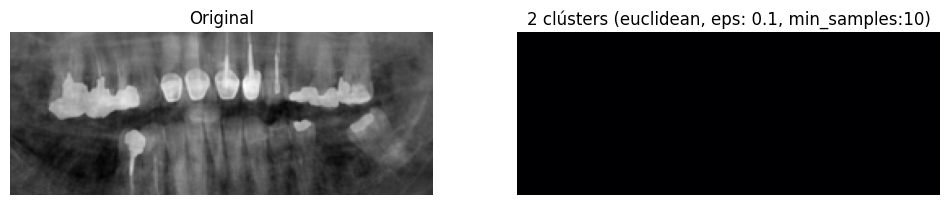

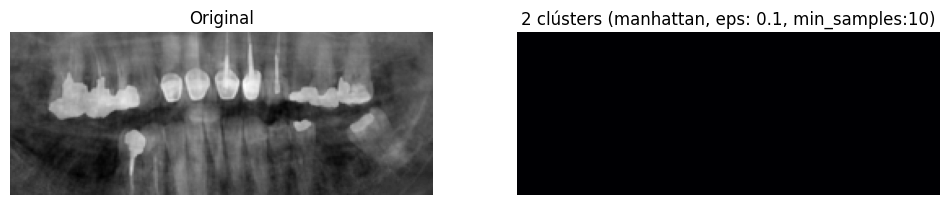

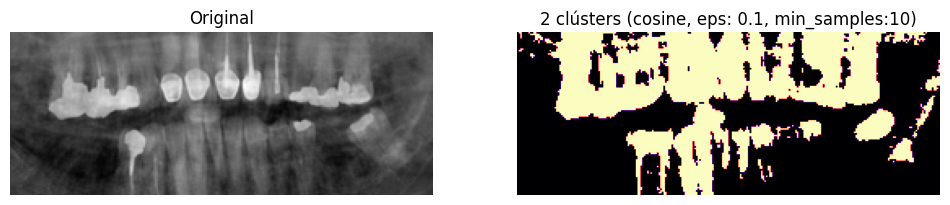

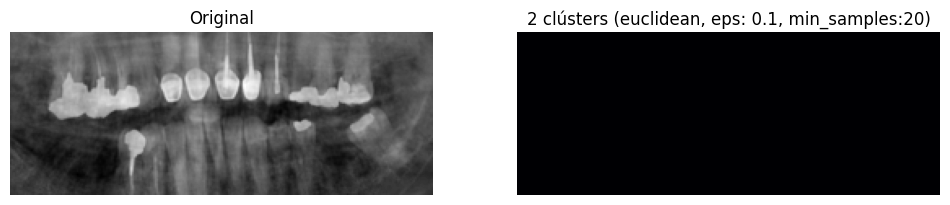

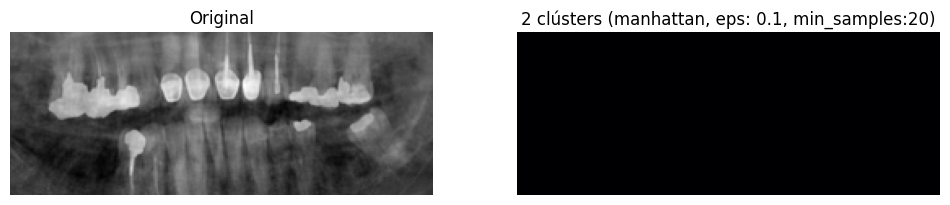

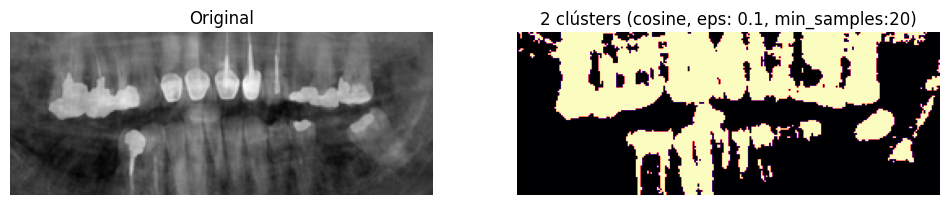

In [39]:
eps_values = [0.001, 0.01, 0.1]
min_samples_values = [5, 10, 20]
metric_values = ['euclidean', 'manhattan', 'cosine']#, 'jaccard']

evaluate_dbscan_hyperparameters(caption4, eps_values, min_samples_values, metric_values)

Vemos que con la métrica de coseno se aisló el ruido de una manera aceptable, como los valores cercanos a las mejillas y partes de las encías y la lengua, resaltandose las áreas correspondientes a los dientes y sus raíces, pero no secciones más densas como la caries.

Usando la métrica `jaccard`, obtuvimos los peores resultados.

La mayoría de intentos con la métrica de `manhattan` y algunas de `ecludean` no identificaron clusters, sin embargo, vemos que para la combinación de hiperparámetros eps=0.01, min_samples=20 y metric='manhattan' o meric='euclidean' se encontraron 25 clústers que corresponden en cierta medida con esas áreas más densas identificables a simple vista en la imagen original:

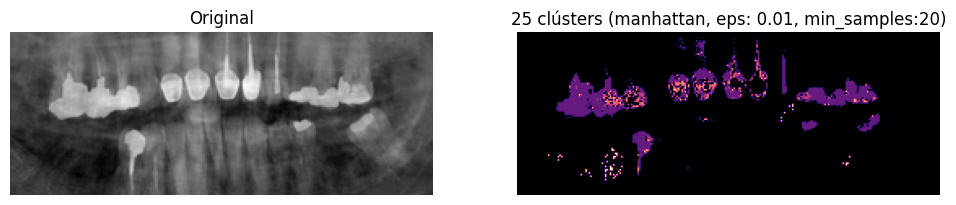

In [34]:
eval_dbscan(caption4, 0.01, 20, 'manhattan')

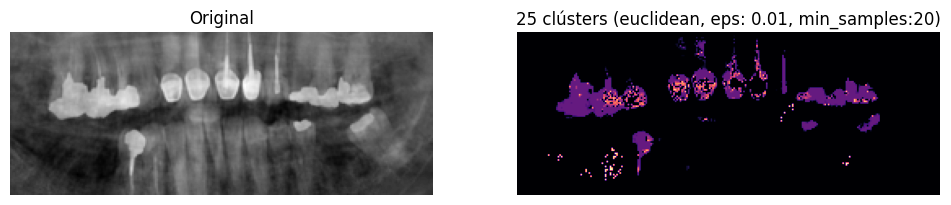

In [35]:
eval_dbscan(caption4, 0.01, 20, 'euclidean')

Una posible razón por la que la métrica `cosine`, no fue efectiva para nuestro escenario se puede deber a que la distancia del coseno se basa en la dirección o el ángulo entre los vectores de píxeles en lugar de su magnitud y es considerada más útil si se desea encontrar áreas donde los vectores de píxeles tengan ángulos agudos entre sí, lo que indica similitud direccional.  En cambio, al usar la distancia euclidiana, revisamos la distancia entre dos píxeles A y B calculada como la longitud del vector que une A y B en el espacio de características.

Basado en lo anterior, podemos restringir ahora nuestra búsqueda de hiperparámetros con cualquiera de estas métricas.  Usamos la euclidiana, con un rango de eps entre 0.01 y 0.025, min_samples entre 10 y 20.

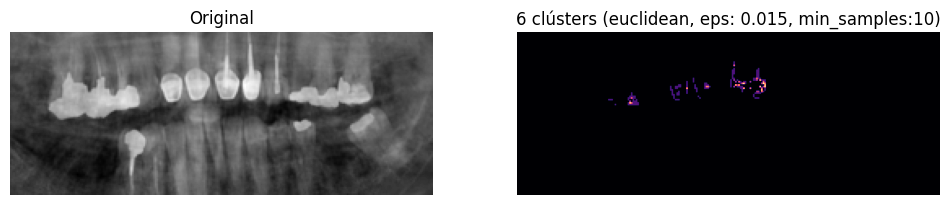

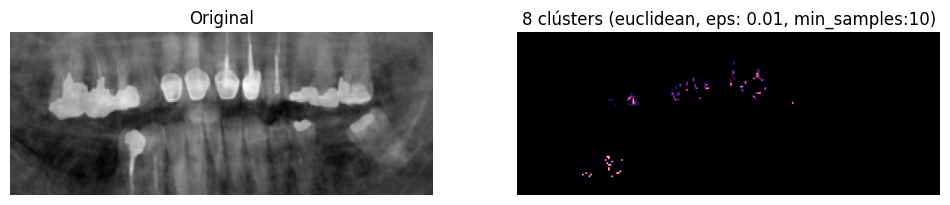

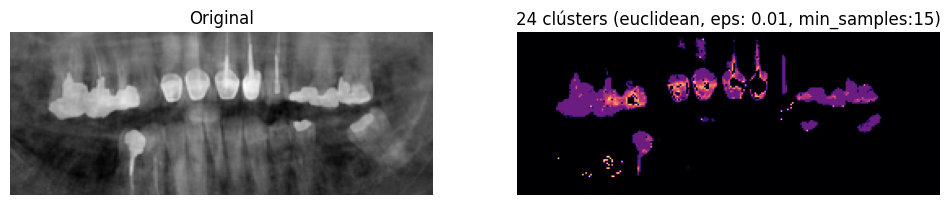

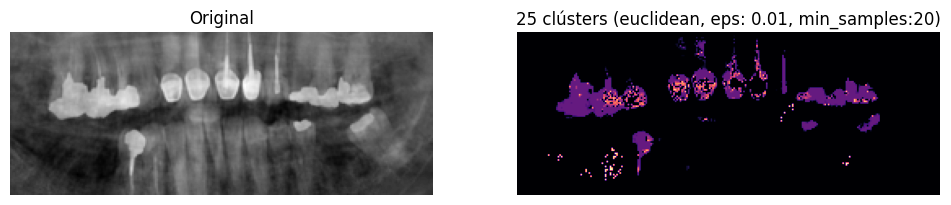

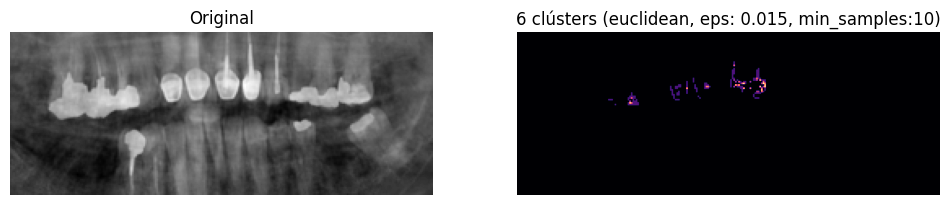

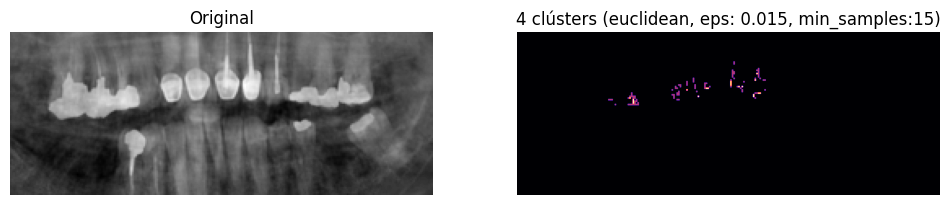

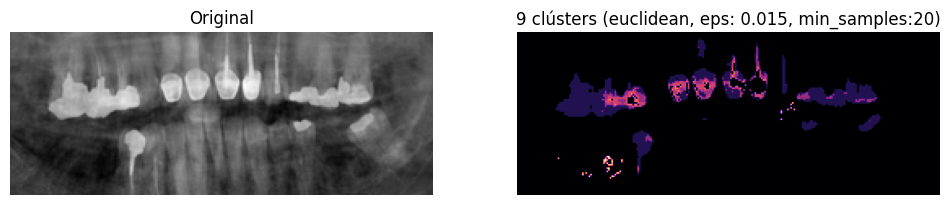

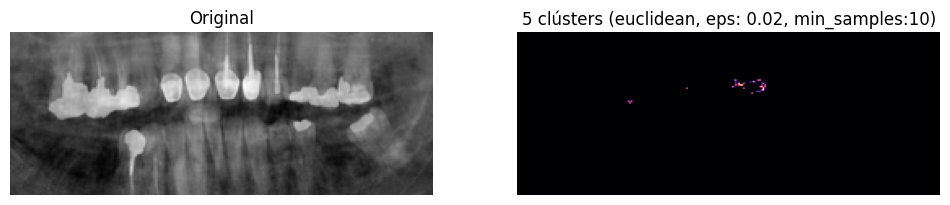

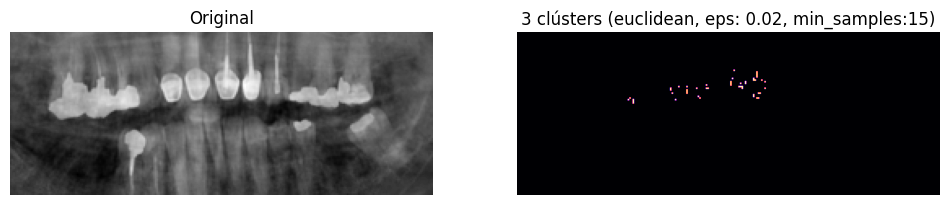

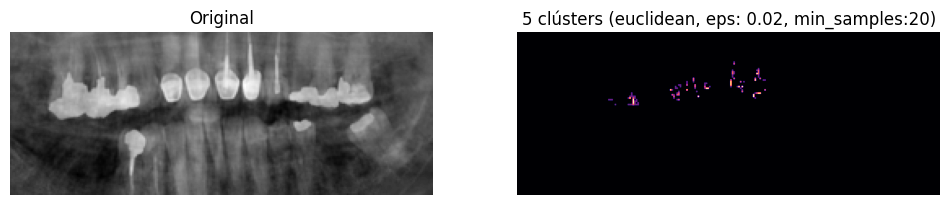

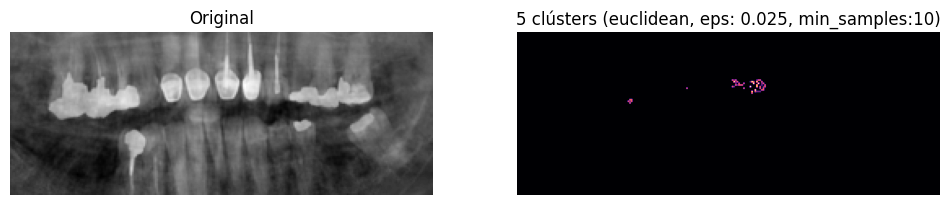

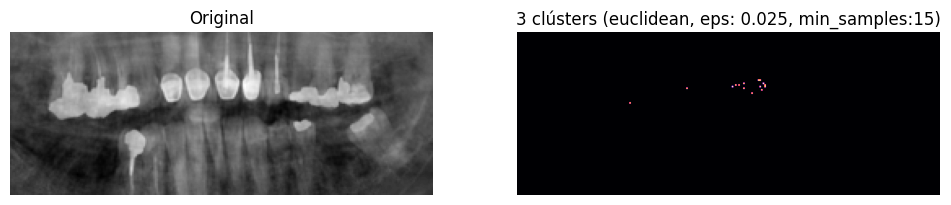

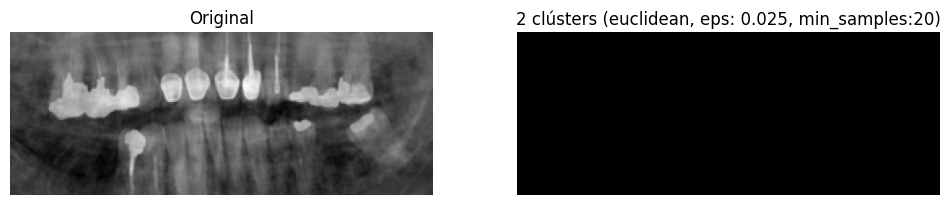

In [51]:
eval_dbscan(caption4, 0.015, 10, 'euclidean')
eps_values = [0.01, 0.015, 0.020, 0.025]
min_samples_values = [10, 15, 20]
metric_values = ['euclidean']

evaluate_dbscan_hyperparameters(caption4, eps_values, min_samples_values, metric_values)

Vemos que con este nuevo intento logramos una mejor segmentación con eps=0.015 y min_samples=0.20.  Con esta combinación de hiperparámetros podemos ver que se encontraron 9 clústers.  Entre más claro el color, indica una mayor densidad y entre más oscuro una menor densidad.  Esto quiere decir que las clústers encontrados corresponden a niveles de densidad, de esta manera podemos interpretar que las áreas en rosada (más densas) podrían corresponder a aquellas con una caries más avanzada, que las moradas (menos densas) alrededor de las rosadas o en otros dientes.

Respecto a el área en la esquina inferior izquierda, de color naranja/amarillo, corresponde a la sección más densa de todos los clústers encontrados, pero para nuestro caso podría considerarse ruido pues corresponde a una parte de encía.

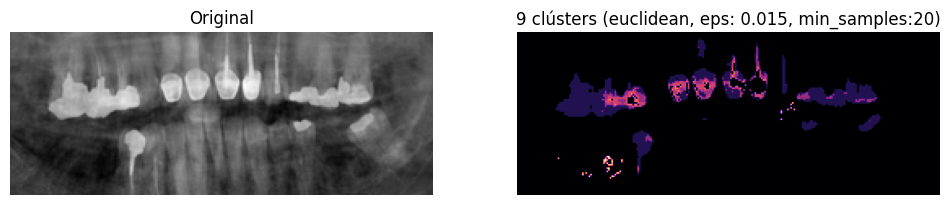

In [53]:
eval_dbscan(caption4, 0.015, 20, 'euclidean')

Ahora, podríamos aplicar DBSCAN sobre el resto de imagenes de nuestro conjunto y registrar la cantidad de clusters encontrados y de esta manera podríamos etiquetar cada imagen con la cantidad de clústers encontrados, aquellas con pocos clústers (entre 0 y 2 clústers) podrían considerarse casos sanos, aquellas con entre 3 y 7 clústers podrían considerarse moderado y con más de 7 clústers podrían considerarse casos graves que requieren de atención prioritaria.

In [ ]:
#tomamos una imagen y la recreamos a partir de sus componentes principales
sample_image = pca_model.inverse_transform([X_reduced[12]])
# la recortamos
caption4 = cut_image(sample_image.reshape((188, 398)), coords=(80, 40, 260, 100), show=True)
# La aplanamos
X4_ = caption4.reshape(-1, 1)

# Aplicamos dbscan con los hiperparámetros encontrados
dbscan4 = DBSCAN(eps=0.015, min_samples=20, metric='euclidean', n_jobs=-1)
dbscan4.fit(X4_)

# y obtenemos el número de clústers
unique_labels = np.unique(dbscan4.labels_)
len(unique_labels)